# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
import pandas as pd

import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split

!pip install category_encoders
import category_encoders as ce

from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, make_scorer

     |████████████████████████████████| 81 kB 1.3 MB/s eta 0:00:011


### Подготовка данных и первичное исследование

In [ ]:
df = pd.read_csv('/datasets/autos.csv')

In [ ]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
131743,2016-03-11 08:38:15,1200,suv,2006,manual,82,niva,150000,11,petrol,lada,yes,2016-03-11 00:00:00,0,19406,2016-03-22 18:47:49
230250,2016-03-19 10:51:33,170,sedan,1994,manual,115,80,150000,0,petrol,audi,yes,2016-03-19 00:00:00,0,85456,2016-03-31 17:47:30
344837,2016-03-13 01:00:06,1700,small,1998,manual,86,a_klasse,150000,7,petrol,mercedes_benz,no,2016-03-12 00:00:00,0,79336,2016-03-13 06:46:57
325101,2016-03-10 19:25:50,750,sedan,1996,manual,90,civic,150000,3,petrol,honda,NaN,2016-03-10 00:00:00,0,61169,2016-03-11 10:26:37
57362,2016-03-06 22:47:08,5500,small,2006,manual,80,golf,150000,10,petrol,volkswagen,no,2016-03-06 00:00:00,0,21483,2016-04-07 03:16:02


In [ ]:
#Подсчитаем и удалим полные дубликаты из таблицы
df.duplicated().sum()

4

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
#Проверим число пропусков в столбцах
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


In [ ]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
144182,2016-03-22 18:44:45,3290,sedan,2001,manual,115,3er,150000,0,petrol,bmw,no,2016-03-22 00:00:00,0,51377,2016-03-24 02:45:39
201782,2016-03-16 23:52:20,4780,sedan,2001,manual,170,3er,150000,9,petrol,bmw,no,2016-03-16 00:00:00,0,14542,2016-04-06 00:45:38
167326,2016-03-12 14:51:00,8750,sedan,2005,auto,177,5er,150000,8,gasoline,bmw,no,2016-03-12 00:00:00,0,48429,2016-03-16 18:17:42
234227,2016-03-13 20:06:16,6100,wagon,2011,manual,105,ibiza,150000,4,gasoline,seat,NaN,2016-03-13 00:00:00,0,65620,2016-03-20 09:15:43
258138,2016-03-16 19:42:10,4200,sedan,2006,manual,110,focus,150000,9,gasoline,ford,NaN,2016-03-16 00:00:00,0,50765,2016-04-07 04:45:54


In [ ]:
#Проверим типы данных в столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

In [ ]:
#Изучим общюю информацию по распределению данных в таблице числовых данных
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
#Изучим первично столюцы с категориальными значениями
# VehicleType, Gearbox, Model, FuelType, Brand, Repaired
print(df['VehicleType'].unique())
print(df['Gearbox'].unique())
print(df['Model'].unique())
print(df['FuelType'].unique())
print(df['Brand'].unique())
print(df['Repaired'].unique())


[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3

Первичные выводы:

1. Полных дубликатов в таблице было не так много, всего 4, их мы удалили сразу
2. Пропуски наблюдаются в столюцах: VehicleType, Gearbox, Model, FuelType и наибольшее колличество пропусков в столбце- Repaired, остальные столбцы не содержат пропусков
3. Типы данных для всх столбцов, кроме столюцов содержащих дату и время: LastSeen, DateCrawled и DateCreated, указаны верно. Однако пока неизвестно нужны ли нам будут эти данные в будущем? Если они понадобятся, мы сможем преобразовать их в нужный формат DateTime
4. В столюце Price есть строки с 0 значением и выброс со значением- 20 000
5. В столюце RegistrationYear есть аномальное значение- 1000 и 9999
6. В столбце Power есть строки с 0 значением и явный выброс со значением- 20 000
7. В столюце NumberOfPictures есть только нулевые значения, его можно будет удалить
8. В столбце Kilometer есть необычно мылые значения - 5000, надо будет изучить их подробнее
9.  В столбце RegistrationMonth, есть значения 0, изучим их колличество
10. В столюце Model есть неявные дубликаты- range_rover и rangerover
11. В столюце Brand, неявные дубликаты отсутствуют
12. В столбце FuelType- gasoline и petrol по сути являются одним и тем-же значением, так как оба означают питание машины от бензина https://economictimes.indiatimes.com/definition/gasoline


### Предобработка данных и исследовательский анализ

Создадим небольшую функцию для анализа данных в числовых столбцах

In [ ]:
def custom_plot(df, x, x_label, y_label, title, bins):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=df, x=x, kde=True, bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    plt.figure(figsize=(19, 7))
    sns.boxplot(data=df, x=x)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

Изучим более пристально числовые аномалии по целевому признаку, выявленны нами на предыдущем этапе

In [ ]:
df[df['Price'] == 0].sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
301446,2016-03-12 09:44:50,0,small,1999,manual,85,punto,150000,6,petrol,fiat,NaN,2016-03-12 00:00:00,0,51107,2016-03-17 05:47:01
155095,2016-03-15 21:58:21,0,small,2000,manual,60,polo,150000,5,petrol,volkswagen,yes,2016-03-15 00:00:00,0,1796,2016-03-17 19:46:00
220084,2016-03-18 03:02:50,0,NaN,2000,NaN,0,NaN,5000,1,NaN,sonstige_autos,NaN,2016-03-18 00:00:00,0,89312,2016-03-22 10:19:05
224252,2016-03-09 09:52:11,0,NaN,2017,manual,80,corsa,150000,10,petrol,opel,NaN,2016-03-09 00:00:00,0,40229,2016-04-07 11:44:33
55931,2016-03-17 19:40:16,0,wagon,1999,manual,0,c_klasse,150000,11,petrol,mercedes_benz,NaN,2016-03-17 00:00:00,0,37154,2016-03-17 19:40:16


In [ ]:
print('Колличество аномальных значений по целевому признаку составляет:',
      round(df[df['Price'] == 0].shape[0] / df.shape[0] * 100),'%')

Колличество аномальных значений по целевому признаку составляет: 3 %


In [ ]:
print('Колличество аномальных значений по целевому признаку составляет:',
      (df[(df['Price'] < 100) & (df['Price'] != 0)].shape[0] / df.shape[0] * 100),'%')

Колличество аномальных значений по целевому признаку составляет: 0.7173394663694214 %


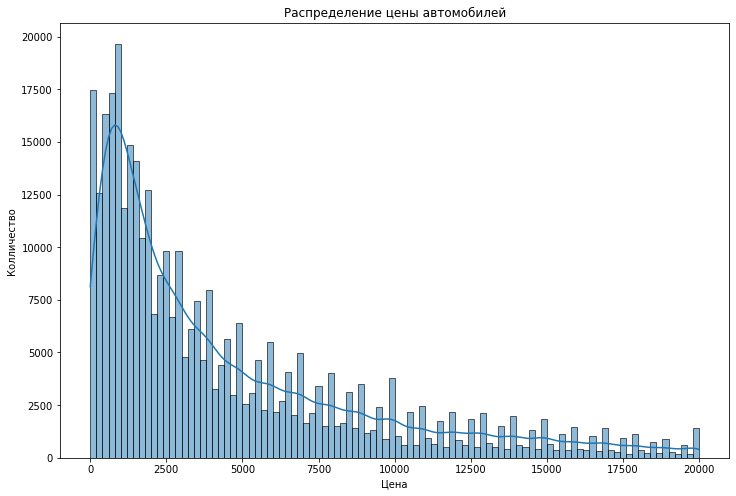

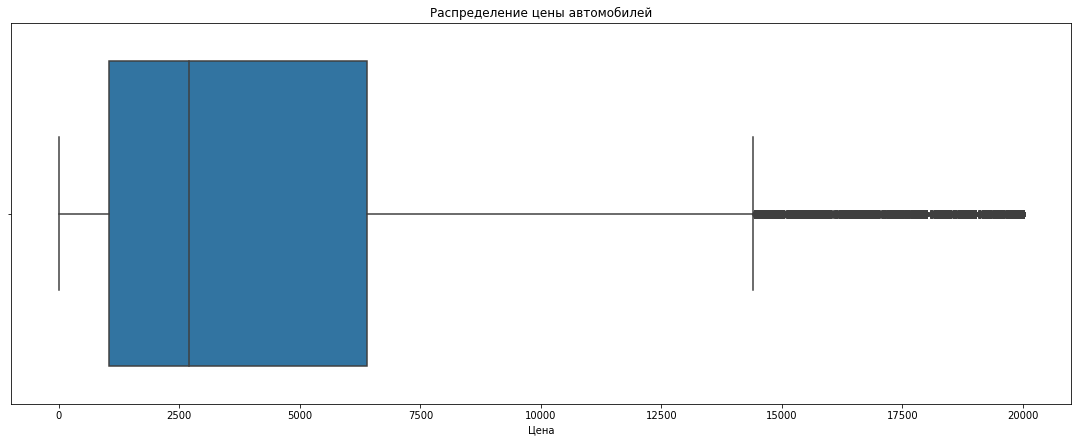

In [ ]:
custom_plot(df, 'Price', 'Цена', 'Колличество', 'Распределение цены автомобилей', 100)


Колличество аномальных значений с нулевой ценой не так велико от общего колличества, поэтому удалим их, какой-либо корреляции в пропусках, также не наблюдается. Также уберем и данные, до 100 евро, так как эти данные кажутся крайне маловероятными, но присутсвуют в таблице в небольшом колличестве

In [ ]:
fixed_df = df.loc[df['Price'] > 100]

Теперь изучим и аномальные значения в столбце с указанием года, насколько мы видели там есть машины созданные очень рано, и поскольку массовое, серийное произодство автомобилей началось около, 1890 года, более ранний год создания довольно маловероятен, то же самое касается и машин созданных после 2023 года, так как это года проведения данного анализа. Изучим какое колличество данных от общих составляют эти машины

In [ ]:
fixed_df[fixed_df['RegistrationYear'] < 1890].RegistrationYear.value_counts()

1000    22
1800     4
1234     3
1600     2
1300     2
1500     2
1602     1
1039     1
1111     1
1001     1
1400     1
Name: RegistrationYear, dtype: int64

In [ ]:
fixed_df[fixed_df['RegistrationYear'] > 2023].RegistrationYear.value_counts()

5000    13
9999    13
6000     5
3000     4
7000     4
4000     3
5911     2
5555     2
4500     2
2500     2
9000     2
3800     1
8500     1
5600     1
3200     1
9450     1
2290     1
3700     1
2900     1
5300     1
4800     1
7100     1
8888     1
4100     1
8200     1
2200     1
2066     1
5900     1
2800     1
7800     1
Name: RegistrationYear, dtype: int64

In [ ]:
print('Колличество аномальных значений по признаку составляет:',
      (fixed_df.loc[(fixed_df['RegistrationYear'] < 1890) | (fixed_df['RegistrationYear'] > 2023)].shape[0] / df.shape[0] * 100),'%')

Колличество аномальных значений по признаку составляет: 0.03132363523485671 %


Данные значения крайне млаовероятны и в них скорее всего допущена ошибка, удалим их, тем более что их количество достаточно мало

In [ ]:
fixed_df = fixed_df.loc[(fixed_df['RegistrationYear'] >= 1890) & (fixed_df['RegistrationYear'] <= 2023)]

Так как данные столбца Power представлены у нас в лошадиных силах, наличие автомобилей с значениями свыше 2000, в принципе не возможно удалим их

In [ ]:
fixed_df[fixed_df['Power'] > 2000].count()['Power']
fixed_df = fixed_df.loc[fixed_df['Power'] < 2000]

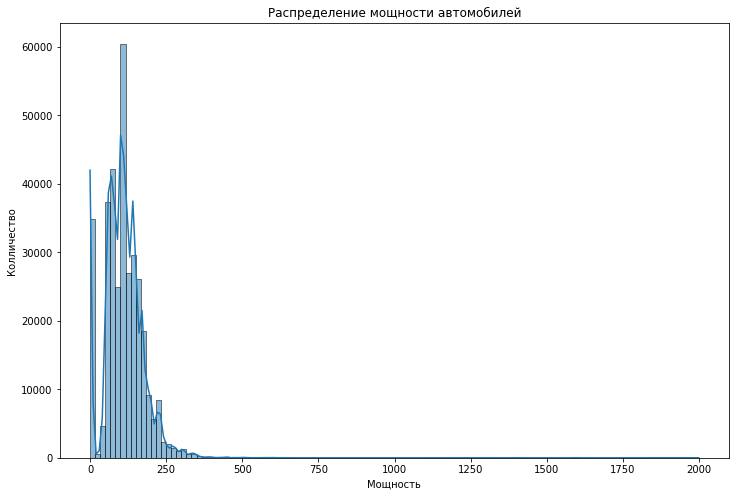

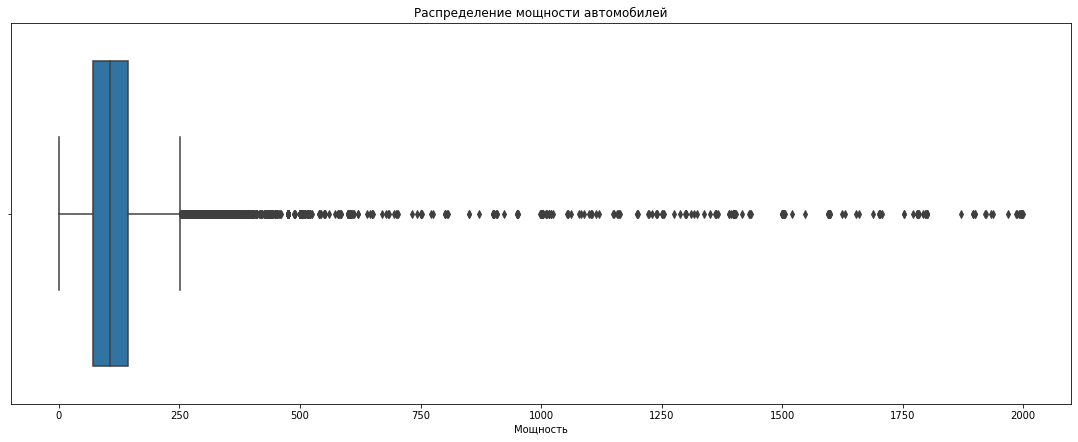

In [ ]:
custom_plot(fixed_df, 'Power', 'Мощность', 'Колличество', 'Распределение мощности автомобилей', 120)

Видим, что в таблице так же присутвует большое кол-во значений возле 0, а так же выбросы начинаются примерно с 500, изучим также значения после 700, так как машины такой мощности достаточно редки, хотя и не невозможны, но это следует дополнительно проверить, на основе моделей машин. Проверим, не затесался ли среди них гоночный болид

In [ ]:
fixed_df.loc[fixed_df['Power'] > 700].sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
240661,2016-03-17 13:53:42,700,small,1996,manual,1275,micra,80000,5,petrol,nissan,no,2016-03-17 00:00:00,0,46446,2016-03-17 14:41:33
54753,2016-03-10 08:55:49,5500,small,2007,NaN,805,corsa,40000,0,petrol,opel,NaN,2016-03-10 00:00:00,0,33034,2016-04-06 07:16:05
49724,2016-03-05 17:48:02,1500,wagon,2003,manual,1001,focus,150000,10,gasoline,ford,NaN,2016-03-05 00:00:00,0,32791,2016-03-12 05:18:00
297505,2016-03-31 08:55:30,650,small,2000,manual,1299,ka,150000,4,petrol,ford,NaN,2016-03-31 00:00:00,0,26871,2016-04-06 03:15:43
22281,2016-03-17 05:03:48,3999,sedan,1998,manual,1993,3er,150000,2,cng,bmw,NaN,2016-03-17 00:00:00,0,33330,2016-03-22 13:16:50
273898,2016-03-30 09:37:16,777,wagon,2002,manual,1783,laguna,150000,2,petrol,renault,no,2016-03-30 00:00:00,0,14669,2016-04-04 21:17:42
264940,2016-03-24 16:44:22,3400,sedan,2002,manual,1433,3er,150000,0,petrol,bmw,no,2016-03-24 00:00:00,0,41836,2016-03-29 01:46:24
234099,2016-03-21 18:56:11,1290,sedan,2000,auto,1800,toledo,150000,6,petrol,seat,no,2016-03-21 00:00:00,0,13581,2016-04-06 21:16:50
101186,2016-03-14 13:58:10,600,wagon,2000,manual,1753,focus,150000,12,gasoline,ford,no,2016-03-14 00:00:00,0,49847,2016-03-23 14:46:49
157954,2016-04-01 22:50:14,1000,bus,1997,manual,1151,sharan,150000,3,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,63691,2016-04-01 22:50:14


In [ ]:
fixed_df.loc[fixed_df['Power'] == 0 ].sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
301935,2016-03-05 18:44:24,1999,small,2005,manual,0,justy,125000,5,petrol,subaru,yes,2016-03-05 00:00:00,0,98634,2016-03-10 13:16:52
54617,2016-03-13 06:36:20,505,small,1998,NaN,0,NaN,125000,0,petrol,sonstige_autos,yes,2016-03-13 00:00:00,0,1744,2016-03-28 11:46:22
7755,2016-03-24 12:37:13,2500,sedan,1996,manual,0,corolla,125000,2,petrol,toyota,NaN,2016-03-24 00:00:00,0,13585,2016-04-01 08:15:55
23627,2016-03-19 14:50:35,150,other,2014,NaN,0,ducato,40000,0,NaN,fiat,NaN,2016-03-19 00:00:00,0,21502,2016-04-06 22:44:23
233318,2016-03-22 12:50:35,3950,small,2007,manual,0,corsa,150000,11,petrol,opel,no,2016-03-22 00:00:00,0,52372,2016-04-06 01:44:23
106517,2016-03-11 13:49:02,1950,wagon,2002,auto,0,golf,150000,2,petrol,volkswagen,no,2016-03-11 00:00:00,0,15711,2016-03-12 03:16:49
120185,2016-03-21 07:55:50,450,NaN,2016,NaN,0,polo,150000,10,petrol,volkswagen,NaN,2016-03-21 00:00:00,0,16515,2016-03-21 09:39:28
202071,2016-03-25 18:54:16,750,small,1986,manual,0,NaN,150000,6,petrol,sonstige_autos,NaN,2016-03-25 00:00:00,0,12557,2016-04-07 01:18:00
193639,2016-03-16 08:52:58,800,small,2000,manual,0,other,125000,2,petrol,peugeot,NaN,2016-03-16 00:00:00,0,50969,2016-03-17 07:17:00
34427,2016-03-05 17:59:15,1111,NaN,2017,manual,0,corsa,150000,0,petrol,opel,NaN,2016-03-05 00:00:00,0,16278,2016-03-06 04:44:35


Насколько вижу, все машины из этой выборки не соответсвуют указанным лошадинным силам (согласно данным из открытых источников)
А значит в данных допушена ошибка, причины которых мы пока не знаем, следовательно удалим их, как и данные в которых мощность указана нулевой

In [ ]:
fixed_df = fixed_df.loc[(fixed_df['Power'] > 30) & (fixed_df['Power'] <= 700)]

Изучим более подробно и столбец с пробегом

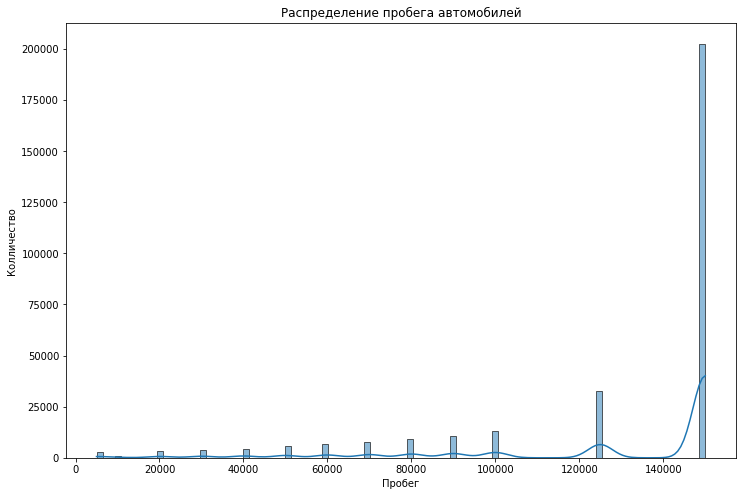

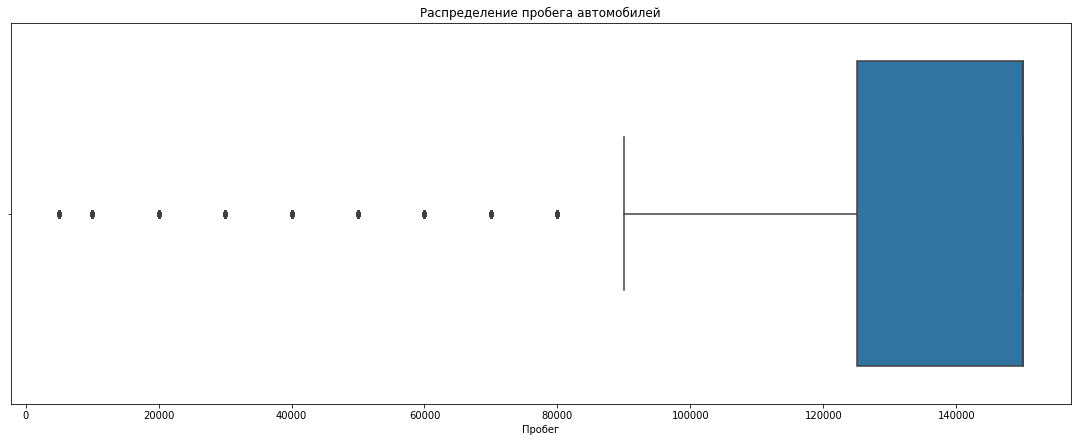

In [ ]:
custom_plot(fixed_df, 'Kilometer', 'Пробег', 'Колличество', 'Распределение пробега автомобилей', 100)

Насколкьо видим, большая часть значений находится на отметке 150 000 и не превышает его, что значит, что скорее всего на сайте есть максимальное указанное значени, выше которого программа не удает указать пробег автомобиля

В столбце RegistrationMonth, есть значения 0, их значение достаточно велико, поэтому оставим их без изменения, так как скорее всего, это может означать, что информация по месяцу регистрации просто не указана на сайте или была удалена из-за какой-то ошибки

In [ ]:
fixed_df.loc[fixed_df['RegistrationMonth'] == 0]['RegistrationMonth'].count()

19386

Также удалим и лишние столюцы, которые в данном случае не дают нам никакой информации, как например пустой столбец- NumberOfPictures, а также столбцы, которые будут нам мало полезны в данном иследованнии: DateCrawled , DateCreated , PostalCode  и LastSeen

In [ ]:
fixed_df.drop(columns=['DateCreated', 'DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen'], inplace=True)

Изучим данные после первичной предобработки

In [ ]:
fixed_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,304148.000000,304148.000000,304148.000000,304148.000000,304148.000000
mean,4842.458116,2003.368416,120.697956,128598.149585,5.975995
std,4587.616788,6.832991,53.779955,36490.445974,3.594610
min,101.000000,1910.000000,31.000000,5000.000000,0.000000
25%,1350.000000,1999.000000,76.000000,125000.000000,3.000000
50%,3199.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6990.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,2019.000000,700.000000,150000.000000,12.000000


Теперь данные выглядят значительно лучше и реалистичнее, переходим к следующему этапу

### Обработка пропусков и дубликатов

Произведем замену неявных дубликатов в столбцах Model- range_rover и rangerover
и в столбце FuelType- gasoline и petrol, которые по сути являются одним и тем-же значением, так как оба означают питание машины от бензина https://economictimes.indiatimes.com/definition/gasoline

In [ ]:
fixed_df['Model'] = fixed_df['Model'].replace('rangerover', 'range_rover')
fixed_df['FuelType'] = fixed_df['FuelType'].replace('gasoline', 'petrol')
fixed_df['FuelType'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [ ]:
fixed_df.isnull().sum()

Price                    0
VehicleType          20840
RegistrationYear         0
Gearbox               5832
Power                    0
Model                11979
Kilometer                0
RegistrationMonth        0
FuelType             19217
Brand                    0
Repaired             46159
dtype: int64

Теперь перейдем к более подробному изучению, пропусков в столбцах

In [ ]:
print(fixed_df['VehicleType'].isnull().sum())
print(fixed_df['VehicleType'].value_counts())
# В пропусках отсутствует корреляция, поэтому заполним пропуски unknown
fixed_df.VehicleType = fixed_df.VehicleType.fillna('unknown')

20840
sedan          82586
small          69076
wagon          58987
bus            26146
convertible    18671
coupe          14523
suv            10926
other           2393
Name: VehicleType, dtype: int64


In [ ]:
print(fixed_df['Gearbox'].isnull().sum())
print(fixed_df['Gearbox'].value_counts())
# В данном случае мы видим что указано все 2 типа коробки передач, соответственно пропуски могут означать другой ее тип, заполним пропуски other
fixed_df.Gearbox = fixed_df.Gearbox.fillna('other')

5832
manual    238316
auto       60000
Name: Gearbox, dtype: int64


In [ ]:
print(fixed_df['Model'].isnull().sum())
print(fixed_df['Model'].value_counts())
# Какая-либо корреляция в пропусках не прослеживается, заменим на unknown
fixed_df.Model = fixed_df.Model.fillna('unknown')

11979
golf                  25837
other                 20484
3er                   17703
polo                  11006
corsa                 10374
                      ...  
samara                    5
kalina                    5
601                       5
serie_3                   3
range_rover_evoque        2
Name: Model, Length: 248, dtype: int64


In [ ]:
print(fixed_df['FuelType'].isnull().sum())
print(fixed_df['FuelType'].value_counts())
# Какая-либо корреляция в пропусках не прослеживается, заменим на unknown, можно было бы предположить что это other, но он выделен в отдельную категорию
fixed_df.FuelType = fixed_df.FuelType.fillna('unknown')

19217
petrol      279350
lpg           4783
cng            496
hybrid         204
other           60
electric        38
Name: FuelType, dtype: int64


In [ ]:
print(fixed_df['Repaired'].isnull().sum())
fixed_df['Repaired'].value_counts()
# Видим, что в данных преобладает число не отремонитрованных машин, заменим пропуски на no, как медианой
fixed_df.Repaired = fixed_df.Repaired.fillna('no')

46159


In [ ]:
fixed_df.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

Теперь когда пропуски удалены, перейдем к работе с данными и обучению модели

## Обучение моделей

In [ ]:
features = fixed_df.drop(['Price'], axis=1)
target = fixed_df['Price']

In [ ]:
#Разделим выборку на 3 части- обучающуюу, валидционную и тестовую, для последующего обучения модели
features_train, features_valid, target_train, target_valid =train_test_split(features, target, test_size=0.4, random_state=42)
features_test, features_valid, target_test, target_valid = train_test_split(features_valid, target_valid, test_size=0.5, random_state=42)

In [ ]:
features_train

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
132268,small,2001,manual,69,2_reihe,150000,6,petrol,peugeot,yes
329379,unknown,2017,manual,116,3er,150000,11,unknown,bmw,no
156940,sedan,1998,manual,101,passat,150000,3,petrol,volkswagen,no
284988,other,1998,manual,102,3er,150000,6,petrol,bmw,yes
27400,bus,1997,manual,102,transporter,150000,12,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
139660,sedan,1998,manual,101,golf,150000,1,petrol,volkswagen,no
301885,sedan,2006,manual,130,megane,150000,3,petrol,renault,yes
153713,wagon,1999,manual,75,astra,150000,12,petrol,opel,yes
171117,sedan,2000,manual,101,passat,150000,4,petrol,volkswagen,yes


Теперь проведем кодирование и масштабирование признаков

In [ ]:
ce_ord = ce.OrdinalEncoder(cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'])
features_train = ce_ord.fit_transform(features_train)
features_valid = ce_ord.transform(features_valid)
features_test = ce_ord.transform(features_test)

In [ ]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

Напишем функцию для расчета RMSE

In [ ]:
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

Модель Линейной регрессии

Проверим работу функции, через алгоритм линейной регрессии без указания гиперпараметров, также возьмем эту модель за отправную точку

In [ ]:
model = LinearRegression()
start_time = time.time()
model.fit(features_train, target_train)
first_time = time.time() - start_time

predictions_valid = model.predict(features_valid)

score = RMSE(target_valid, predictions_valid)

start_time2 = time.time()
predictions_test = model.predict(features_test)
second_time = time.time() - start_time2

end_result = RMSE(target_test, predictions_test)

Linear_Regressions = (score, first_time, second_time)

print("Точность наилучшей модели на валидационной выборке:", score)
print('Точность на тестовой выборке-', end_result)
print("Время обучения модели-", first_time, ', время предсказания модели -', second_time)

Точность наилучшей модели на валидационной выборке: 3058.15317932484
Точность на тестовой выборке- 3064.6408378003216
Время обучения модели- 0.03862953186035156 , время предсказания модели - 0.003953456878662109


Обучим LGBM модель

In [ ]:
best_model = None
best_result= 5000
best_est = 0
best_depth = 0
best_leaf = 0
train_time = 0

for est in [10,50]:
    start_time = time.time()
    for depth in [10,15,30]:
        for leaf in [10,20]:
            model = LGBMRegressor(random_state=12345, learning_rate= 0.1, n_estimators=est, max_depth=depth, num_leaves = leaf)
            model.fit(features_train, target_train)
            first_time = time.time() - start_time

            predictions_valid = model.predict(features_valid)

            score = RMSE(target_valid, predictions_valid)

            if score < best_result:
                best_model = model
                best_result = score
                best_est = est
                best_depth = depth
                best_leaf = leaf
                train_time = first_time

start_time2 = time.time()
predictions_test = best_model.predict(features_test)
prediction_time = time.time() - start_time2
end_result = RMSE(target_test, predictions_test)

lgbm = (best_result, train_time, prediction_time)

print("Точность наилучшей модели на валидационной выборке:", best_result, "Лучший параметр n_estimators:", best_est, "Лучшая глубина:", best_depth, "Лучший параметр leaf:", leaf)
print('Точность на тестовой выборке-', end_result)
print("Время обучения модели-", train_time, ', время предсказания модели -', prediction_time)

Точность наилучшей модели на валидационной выборке: 1858.6579571795485 Лучший параметр n_estimators: 50 Лучшая глубина: 15 Лучший параметр leaf: 20
Точность на тестовой выборке- 1886.6672214386874
Время обучения модели- 13.102743864059448 , время предсказания модели - 0.2902359962463379


Обучим RandomForest модель

In [ ]:
best_model = None
best_result= 5000
best_est = 0
best_depth = 0
train_time = 0

for est in range (10, 60, 10):
    start_time = time.time()
    for depth in range (1, 20):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        first_time = time.time() - start_time

        predictions_valid = model.predict(features_valid)

        score = RMSE(target_valid, predictions_valid)

        if score < best_result:
            best_model = model
            best_result = score
            best_est = est
            best_depth = depth
            train_time = first_time

start_time2 = time.time()
predictions_test = best_model.predict(features_test)
prediction_time = time.time() - start_time2
end_result = RMSE(target_test, predictions_test)

RandomForest = (best_result, train_time, prediction_time)
print("Точность наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)
print('Точность на тестовой выборке-', end_result)
print("Время обучения модели-", train_time, ', время предсказания модели -', prediction_time)

Точность наилучшей модели на валидационной выборке: 1598.8350605163996 Количество деревьев: 50 Максимальная глубина: 19
Точность на тестовой выборке- 1623.7301778044005
Время обучения модели- 235.50691890716553 , время предсказания модели - 0.878594160079956


Обучим DecisionTree модель

In [ ]:
best_model = None
best_result= 5000
best_depth = 0
train_time = 0

for depth in range(1, 20):
    start_time = time.time()
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    first_time = time.time() - start_time

    predictions_valid = model.predict(features_valid)

    score = RMSE(target_valid, predictions_valid)

    if score < best_result:
        best_model = model
        best_result = score
        best_depth = depth
        train_time = first_time

start_time2 = time.time()
predictions_test = best_model.predict(features_test)
prediction_time = time.time() - start_time2
end_result = RMSE(target_test, predictions_test)

DecisionTree = (best_result, train_time, prediction_time)
print("Точность наилучшей модели на валидационной выборке:", best_result, "Максимальная глубина:", best_depth)
print('Точность на тестовой выборке-', end_result)
print("Время обучения модели-", train_time, ', время предсказания модели -', prediction_time)

Точность наилучшей модели на валидационной выборке: 1918.649862897597 Максимальная глубина: 14
Точность на тестовой выборке- 1922.4669066163297
Время обучения модели- 0.4857645034790039 , время предсказания модели - 0.011472702026367188


Обучим CatBoost модель

In [ ]:
best_model = None
best_result= 5000
best_it = 0
best_depth = 0
train_time = 0

for it in [10,50,100]:
    start_time = time.time()
    for depth in range (1,15):
        model = CatBoostRegressor(random_state=12345, iterations= it, max_depth= depth, learning_rate = 0.1, silent=True)
        model.fit(features_train, target_train)
        first_time = time.time() - start_time

        predictions_valid = model.predict(features_valid)

        score = RMSE(target_valid, predictions_valid)

        if score < best_result:
            best_model = model
            best_result = score
            best_it = it
            best_depth = depth
            train_time = first_time

start_time2 = time.time()
predictions_test = best_model.predict(features_test)
prediction_time = time.time() - start_time2
end_result = RMSE(target_test, predictions_test)

CatBoost = (best_result, train_time, prediction_time)
print("Точность наилучшей модели на валидационной выборке:", best_result, "Лучший параметр iterations:", best_it, "Лучшая глубина:", best_depth)
print('Точность на тестовой выборке-', end_result)
print("Время обучения модели-", train_time, ', время предсказания модели -', prediction_time)

Точность наилучшей модели на валидационной выборке: 1651.6259003577857 Лучший параметр iterations: 100 Лучшая глубина: 14
Точность на тестовой выборке- 1674.0717408506844
Время обучения модели- 89.49814438819885 , время предсказания модели - 0.04559016227722168


## Анализ моделей и итоговый вывод

In [ ]:
display(pd.DataFrame([Linear_Regressions, lgbm, RandomForest, DecisionTree, CatBoost],
             columns=['RMSE', 'Время обучения', 'Время предсказания'],
                      index=['Linear_Regression','LGBM','RandomForest', 'DecisionTree', 'CatBoost']))

,RMSE,Время обучения,Время предсказания
Linear_Regression,3058.153179,0.038630,0.003953
LGBM,1858.657957,13.102744,0.290236
RandomForest,1598.835061,235.506919,0.878594
DecisionTree,1918.649863,0.485765,0.011473
CatBoost,1651.625900,89.498144,0.045590


Выводы:
1. По итогам работы, самое высокое качество предсказания показала модель- RandomForest
2. Самую высокую скорость обучения и предсказания показала модель Линейной регрессии, но это произошло из-за отсутсвия необходимости в переборе гиперпараметров, а самую большую скорость обучения из числа моделей, работающих с перебором гиперпараметров, показало Дерево решений. Cамую высокую скорость предсказания среди можелей с перебором гиперпараметров, также показала модель Дерева решений
3. Самое низкое качество предсказания показала модель Линейной регрессии

По итогу, наилучший результат с точки зрения качества предсказний, показала модель- RandomForest, однако она, в то-же время показала и самое долгое время обучения и предсказания, намного больше других моделей, Таким образом если клиент хочет воспользоваться некоторой золотой серединой, приоретезировав скорость обучения и предсказания, пусть даже немного в ущерб результатам обучения модели, наиболе оптимальной золотой серединой, для него будет модель- CatBoost.
Она показала намного большую скорость обучения и предсказания, но с небольшим уменьшением качества предсказания.
Однако, если заказчик хочет приоретезировать именно качество предсказания (пусть даже в ущерб времени обучения) оптимальнее всего будет использовать именно модель- RandomForest.